In [1]:
import pandas as pd
from __future__ import division
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from copy import deepcopy
import pickle
import sys

In [2]:
df = pd.read_csv('/users/markregalla/desktop/metis/Project3/data/LoanStats3d.csv', header=1)
#df = df.dropna()

/Users/markregalla/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (0,19) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [41]:
#df = df.drop(180103, axis=0)
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#pd.options.display.mpl_style = 'default'

In [3]:
#clean data
df['emp_title'] = df['emp_title'].str.lower()
df['emp_title'] = df['emp_title'].str.strip()
df['int_rate'] = df['int_rate'].str.strip('%')
df['int_rate'] = df['int_rate'].map(lambda x: float(x))

In [ ]:
#df[(df['emp_title'] == 'analytics manager') | (df['emp_title'] == 'aquatics manager')]
#df['int_rate'][df['emp_title'] == 'manager'].mean()
#['recruitment consultant', 'permitting consultant'] 'recruiting consultant'
df[(df['emp_title'] == 'recruiting consultant') | (df['emp_title'] == 'recruitment consultant') | (df['emp_title'] == 'permitting consultant')]

In [11]:
i = 99
emp_title_list = ''
unique_emps = ''
emp_title_list = deepcopy(df['emp_title'])
unique_emps = deepcopy(df['emp_title'].unique())
#unique_emps = deepcopy(unique_emps[:1000])
unique_emps = unique_emps.tolist()
#emp_title_list = emp_title_list.dropna()
#emp_title_list = emp_title_list.tolist()
print type (unique_emps)
len(unique_emps)
#type(unique_emps)

<type 'list'>


49524

In [12]:
reduced_test_list = deepcopy(emp_title_list[:20000])
len_reduced_list = len(reduced_test_list)
reduced_test_list

0                    instructional designer
1           customer service representative
2                                 wire tech
3                                       csr
4                            branch manager
5                      crm business analyst
6                                     sales
7                    billing representative
8                           project manager
9                 substance abuse counselor
10                         customer service
11       associate manager public relations
12                              tax manager
13                 wireless network support
14                             lead teacher
15                                   deputy
16                             csm   teller
17         correctional security officer iv
18                                custodial
19                                  teacher
20                    insurance coordinator
21                      sr. sales associate
22            associate director

##FuzzyWuzzy emp title reduction algorithm
#####First try

In [9]:
%%time
#innerlist = []
#untouched = emp_title_list

def reducedown(title_list, bigDict = {}):
    i = 1
    untouched = []
    matchedindeces = []
    while i < len(title_list):
        if fuzz.ratio(title_list[0], title_list[i]) >= 85:
            matchedindeces.append(title_list)  #msut assign same index as total emp_title_list
            #print title_list[i]
        else:
            untouched.append(title_list[i])
        i += 1
    
    bigDict[title_list[0]] = matchedindeces
    print 'Length of untouched: ' + str(len(untouched))
    if len(untouched) > 1:
        reducedown(untouched)
    return bigDict

#theDict = reducedown(emp_title_list)
thetestDict = reducedown(reduced_test_list)

print 'Done.'

TypeError: object of type 'enumerate' has no len()

######Second try.  Direct string comparison only

In [ ]:
%%time

def reducedown(reduced_test_list, length_to_run):
    i = 0
    matchedindeces = []
    bigDict = {}

    while i < length_to_run:
        k = i + 1
        if (reduced_test_list[i] != 'Viewd' and reduced_test_list[i] != 'NaN'):
            matchedindeces.append(i)
            while k < length_to_run:
                if (reduced_test_list[k] != 'Viewd' and reduced_test_list[k] != 'NaN'):
                    try:
                        if reduced_test_list[i] == reduced_test_list[k]:
                            matchedindeces.append(k)
                            reduced_test_list[k] = 'Viewd'
                    except:
                        pass
                k += 1
        bigDict[reduced_test_list[i]] = matchedindeces
        matchedindeces = []
        i += 1
    
    return bigDict

theDict = reducedown(emp_title_list, len(emp_title_list))

#####Second try.  with fuzzy wuzzy

In [13]:
%%time

#from IPython.display import clear_output

#def reducedown(reduced_test_list, length_to_run):
theDict = {}
i = 0
while i < len(unique_emps):
    k = i + 1
    firsttime = True
    foundone = False
        #matchedindeces.append(i)
    while k < len(unique_emps): #length_to_run:
        iterK = True
        try:
            if fuzz.ratio(unique_emps[i], unique_emps[i + k]) >= 85:
                iterK = False
                foundone = True
                if firsttime == False:
                    theDict[unique_emps[i]].append(unique_emps[i + k])
                    unique_emps.pop(i + k)
                if firsttime == True:
                    theDict[unique_emps[i]] = [unique_emps[i + k]]
                    unique_emps.pop(i + k)
                    firsttime = False   
        except:
            pass
        if iterK == True:
            k += 1
    if foundone == False:
        theDict[unique_emps[i]] = ''
    i += 1
    
    #clear_output()
    sys.stdout.write("\r" + str(i))
    #return reduced_test_list

#print len(unique_emps)
#moreUniqueEmpList = reducedown(unique_emps, 1000)#49524)

34301CPU times: user 54min 37s, sys: 52.2 s, total: 55min 29s
Wall time: 55min 54s


In [56]:
print theDict['analytics manager']

['aquatics manager']


In [97]:
print theDict['recruiting consultant']

['recruitment consultant', 'permitting consultant']


#Assemble dictionary of results

In [94]:
%%time

resultDict = {}
for i in range(len(theDict.keys())):
    alength = df[(df['emp_title'] == theDict.keys()[i]) & (df['grade'] == 'A')]
    restlength = df[(df['emp_title'] == theDict.keys()[i]) & (df['grade'] != 'A')]
    if theDict.values()[i] != '':
        for k in range(len(theDict.values()[i])):
            alength = alength.append(df[(df['emp_title'] == theDict.values()[i][k]) 
                                        & (df['grade'] == 'A')])
            restlength = restlength.append(df[(df['emp_title'] == theDict.values()[i][k]) 
                                        & (df['grade'] != 'A')])
    if len(restlength) != 0:
        resultDict[theDict.keys()[i]] = [str(float(len(alength)) / len(restlength)),
                                         alength['int_rate'].mean(), 
                                         restlength['int_rate'].mean()]
    if len(restlength) == 0:
        resultDict[theDict.keys()[i]] = [1.0, alength['int_rate'].mean(), 
                                         restlength['int_rate'].mean()]
    #if i == 50:
    #    break
    sys.stdout.write("\r" + str(i))
#len(alength)


34300CPU times: user 1h 2min 1s, sys: 53.3 s, total: 1h 2min 55s
Wall time: 1h 3min 15s


In [28]:
from operator import itemgetter
#for m in sorted(resultDict.items(), key=itemgetter(1)):
#    print m
resultdf = pd.DataFrame(resultDict)
resultdf.set_index('% A loans', 'Ave. % Rate (A loans)', 'Ave % Rate (All loans)')

KeyError: '% A loans'

In [18]:
bigratesDict = {}
for z in range(len(resultDict)):
    if resultDict.values()[z][0] > 1.0:
        bigratesDict[resultDict.keys()[z]] = resultDict.values()[z]
    z += 1
    sys.stdout.write("\r" + str(z))
bigratesDict

34301

{'aviation solutions manager, caribbean': ['0.0', nan, 10.49],
 'xray tech': ['0.0625', 6.39, 14.985625],
 'director of early childhood education': ['0.0', nan, 9.49],
 'telecine operator': ['0.0', nan, 10.99],
 'financial/admin mananger': ['0.0', nan, 9.49],
 'school bus mechanic': ['0.0', nan, 10.99],
 'hr rep/ accts payable': ['0.0', nan, 18.84],
 'sr. teamlead operations': ['0.0', nan, 13.33],
 'controller/interim cfo': ['0.0', nan, 12.99],
 'vp of payroll': ['0.0', nan, 11.53],
 'head of rigging': ['0.0', nan, 13.33],
 'deal desk': ['0.0', nan, 25.57],
 'systems engineer / site mgr': ['0.0', nan, 11.44],
 'chief perfusionist': ['0.0', nan, 12.29],
 'vp of risk and underwriting': ['0.0', nan, 15.61],
 'u.s. administrative law judge': ['0.0', nan, 10.99],
 'night manager': ['0.0588235294118', 6.92, 14.482941176470588],
 'spc (e4)': ['0.0', nan, 11.53],
 'e7 chief': ['0.0', nan, 12.69],
 'health information management tech': ['0.0', nan, 12.39],
 'yard foreman': ['0.5', 5.93, 13.4899

In [24]:
#print resultDict.values()[34][0] > 1.0
print len(bigratesDict)

29694


In [40]:
#run each job title through these lines to get percentage of A grade loans for that job title
#assign it to new dataframe or list or something
for i in range(len(thedict.values()[0])):
    alength = df[(df['emp_title'] == theDict.keys()[3]) & (df['grade'] == 'A')]
    restlength = df[(df['emp_title'] == theDict.keys()[3]) & (df['grade'] != 'A')]
print 'No. of Grade A Loans: ' + str(len(alength))
print 'Total no. of loans: ' + str(len(restlength))
print float(len(alength)) / len(restlength)

No. of Grade A Loans: 0
Total no. of loans: 5
0.0


In [15]:
with open('totaldict.pkl', 'w') as picklefile:
    pickle.dump(theDict, picklefile)

In [26]:
with open('resultdict.pkl', 'w') as picklefile:
    pickle.dump(resultDict, picklefile)

In [26]:
with open('resultdf.pkl', 'w') as picklefile:
    pickle.dump(resultdf, picklefile)

In [8]:
with open("totaldict.pkl", 'r') as picklefile: 
    theDict = pickle.load(picklefile)

In [7]:
with open("resultAndInterestdict.pkl", 'r') as picklefile: 
    resultDict = pickle.load(picklefile)

In [6]:
len(df['emp_title'].unique()) / len(df)

0.27497445920135033

In [73]:
df_emp_title = df['emp_title']
df_emp_title = df_emp_title.dropna()    #dropping na to the entire dataframe was dropping most data
print len(df_emp_title[df_emp_title.str.contains('abuse')])
df_emp_title[df_emp_title.str.contains('abuse')]
#print len(df['emp_title'].str.contains('manager')) result = 180104 (not sure why)

14


9          substance abuse counselor
8416       substance abuse counselor
28535       child abuse investigator
39218     substance abuse caseworker
75810     substance abuse prevention
81723      substance abuse counselor
87654      substance abuse counselor
92824      substance abuse counselor
101746     substance abuse counselor
102967      abuse/neglect specialist
131809     substance abuse counselor
167716      substance abuse couselor
171731     substance abuse counselor
177316     substance abuse therapist
Name: emp_title, dtype: object

In [10]:
df[df['grade'] == 'A'].describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
count,31826.000000,31826.000000,31826.000000,31826.00000,31826.000000,31826.000000,31826.000000,31826.000000,31826.000000,14386.000000,3910.000000,31826.000000,31826.000000,31826.000000,31826.000000,31826.000000,31826.000000,31826.000000,31826.000000,31826.000000,31826.000000,31826.000000,31826,31826,31826.000000,31826.000000,6835.000000,31826
mean,47565254.487526,14523.588418,14523.588418,14520.21539,440.737914,89211.482914,16.010591,0.250016,0.306479,34.492076,66.836061,12.218501,0.163703,20090.502388,26.939389,12093.448115,12090.672566,2842.199323,2841.500845,2424.624555,417.548639,0.026130,0,0,883.795537,0.012003,43.702414,1
std,5473584.328923,7530.346367,7530.346367,7528.76748,229.626062,70880.826260,7.378954,0.732022,0.584444,21.320648,28.178196,5.644222,0.560639,27366.409938,11.851458,6916.145746,6914.780457,3090.416855,3089.668518,2974.645850,277.675174,0.860626,0,0,2599.657453,0.115617,20.611193,0
min,232049.000000,1000.000000,1000.000000,1000.00000,30.540000,7000.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,1
25%,43446284.250000,8500.000000,8500.000000,8500.00000,260.100000,55000.000000,10.460000,0.000000,0.000000,17.000000,49.000000,8.000000,0.000000,7576.750000,18.000000,6982.150000,6982.150000,1242.670000,1242.670000,1016.410000,210.690000,0.000000,0,0,274.780000,0.000000,28.000000,1
50%,47347008.500000,12800.000000,12800.000000,12800.00000,377.090000,75000.000000,15.510000,0.000000,0.000000,32.000000,65.000000,11.000000,0.000000,13556.500000,25.000000,10785.470000,10781.960000,2070.930000,2070.930000,1690.070000,348.980000,0.000000,0,0,404.330000,0.000000,44.000000,1
75%,51856407.250000,20000.000000,20000.000000,20000.00000,607.810000,105000.000000,21.120000,0.000000,1.000000,50.000000,83.000000,15.000000,0.000000,23736.750000,34.000000,16755.340000,16755.340000,3330.112500,3329.890000,2728.540000,552.225000,0.000000,0,0,619.930000,0.000000,61.000000,1
max,57164962.000000,35000.000000,35000.000000,35000.00000,1099.850000,7000000.000000,39.990000,14.000000,5.000000,117.000000,120.000000,56.000000,15.000000,1043860.000000,96.000000,33363.530000,33363.530000,36666.420000,36666.420000,35000.000000,1832.830000,61.660000,0,0,35387.240000,3.000000,145.000000,1


179591


(array([  3.68600000e+03,   3.35360000e+04,   4.96370000e+04,
          3.64810000e+04,   2.42580000e+04,   1.30270000e+04,
          7.12000000e+03,   4.43000000e+03,   2.44800000e+03,
          1.72000000e+03,   7.76000000e+02,   5.35000000e+02,
          7.59000000e+02,   2.83000000e+02,   1.67000000e+02,
          3.23000000e+02,   1.25000000e+02,   1.55000000e+02,
          8.30000000e+01,   4.20000000e+01]),
 array([   3000.,   22750.,   42500.,   62250.,   82000.,  101750.,
         121500.,  141250.,  161000.,  180750.,  200500.,  220250.,
         240000.,  259750.,  279500.,  299250.,  319000.,  338750.,
         358500.,  378250.,  398000.]),
 <a list of 20 Patch objects>)

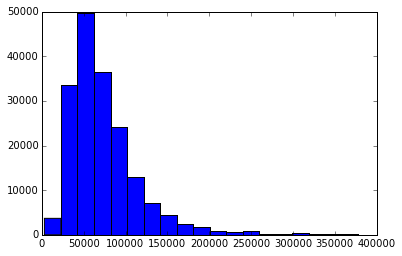

In [36]:
#%matplotlib inline
incomes = df['annual_inc'].dropna()
small_incs = [x for x in incomes if x < 400000]
print len(small_incs)
plt.hist(small_incs, bins=20)

In [11]:
df_A_only = df[df['grade'] == 'A']
A_incomes = df_A_only['annual_inc'].dropna()
A_small_incs = [x for x in A_incomes if x < 200000]
plt.hist(A_small_incs, bins=20, histtype='bar')
#plt.legend()

(array([   40.,   421.,  1406.,  2840.,  3675.,  2992.,  3645.,  3394.,
         2695.,  2441.,  1588.,  1370.,  1098.,   730.,   764.,   424.,
          311.,   399.,   204.,    83.]),
 array([   7000.  ,   16649.95,   26299.9 ,   35949.85,   45599.8 ,
          55249.75,   64899.7 ,   74549.65,   84199.6 ,   93849.55,
         103499.5 ,  113149.45,  122799.4 ,  132449.35,  142099.3 ,
         151749.25,  161399.2 ,  171049.15,  180699.1 ,  190349.05,  199999.  ]),
 <a list of 20 Patch objects>)

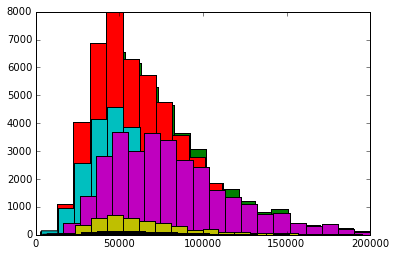

In [35]:
df_A_only = df[df['grade'] == 'A']
A_incomes = df_A_only['annual_inc'].dropna()
A_small_incs = [x for x in A_incomes if x < 200000]
plt.hist(A_small_incs, bins=20, histtype='bar')
plt.legend()

df_B_only = df[df['grade'] == 'B']
B_incomes = df_B_only['annual_inc'].dropna()
B_small_incs = [x for x in B_incomes if x < 200000]
plt.hist(B_small_incs, bins=20, histtype='bar')
plt.legend()

df_C_only = df[df['grade'] == 'C']
C_incomes = df_C_only['annual_inc'].dropna()
C_small_incs = [x for x in C_incomes if x < 200000]
plt.hist(C_small_incs, bins=20, histtype='bar')
plt.legend()

df_D_only = df[df['grade'] == 'D']
D_incomes = df_D_only['annual_inc'].dropna()
D_small_incs = [x for x in D_incomes if x < 200000]
plt.hist(D_small_incs, bins=20, histtype='bar')
plt.legend()

df_E_only = df[df['grade'] == 'E']
E_incomes = df_A_only['annual_inc'].dropna()
E_small_incs = [x for x in E_incomes if x < 200000]
plt.hist(E_small_incs, bins=20, histtype='bar')
plt.legend()

df_F_only = df[df['grade'] == 'F']
F_incomes = df_F_only['annual_inc'].dropna()
F_small_incs = [x for x in F_incomes if x < 200000]
plt.hist(F_small_incs, bins=20, histtype='bar')
plt.legend()

df_G_only = df[df['grade'] == 'G']
G_incomes = df_G_only['annual_inc'].dropna()
G_small_incs = [x for x in G_incomes if x < 200000]
plt.hist(G_small_incs, bins=20, histtype='bar')
plt.legend()

plt.show()

In [22]:
#%matplotlib inline
#df_by_grade = []
#k = 1

print sorted(df['grade'].unique())
#for i in (df['grade'].unique()):
    #print i
#    df_by_grade = df[df['grade'] == i] 
    #print k
#    k += 1

#print len(df_by_grade)
'''
df_A_only = df[df['grade'] == 'A']
A_incomes = df_A_only['annual_inc'].dropna()
A_small_incs = [x for x in A_incomes if x < 200000]
plt.hist(small_incs, bins=20)
'''

#df_by_grade

[nan, 'A', 'B', 'C', 'D', 'E', 'F', 'G']


"\ndf_A_only = df[df['grade'] == 'A']\nA_incomes = df_A_only['annual_inc'].dropna()\nA_small_incs = [x for x in A_incomes if x < 200000]\nplt.hist(small_incs, bins=20)\n"

In [5]:
interestRates = df['int_rate'].dropna()
#interestRates = interestRates.map(lambda x: float(x.strip('%')))

In [9]:
%%time
plt.hist(interestRates, bins=100)

CPU times: user 118 ms, sys: 2.23 ms, total: 121 ms
Wall time: 119 ms


(array([  1314.,      0.,   2725.,   1178.,   3849.,   2471.,   5218.,
          1212.,   1597.,   1737.,   8106.,      0.,   8714.,      0.,
          2020.,      0.,   6541.,   2109.,      0.,   7581.,      0.,
          2271.,      0.,   8110.,      0.,   2560.,   7300.,      0.,
          2485.,  11100.,      0.,   8225.,   2694.,   7928.,      0.,
          2543.,   7990.,   2463.,      0.,   6267.,   2004.,      0.,
             0.,   7475.,      0.,   1594.,      0.,   5580.,      0.,
          5339.,      0.,   3814.,   4617.,      0.,   3238.,   1850.,
             0.,   1959.,   1677.,   1709.,      0.,   1389.,      0.,
             0.,   1383.,      0.,   1061.,      0.,      0.,   1057.,
           881.,      0.,      0.,      0.,   1356.,      0.,      0.,
             0.,    986.,      0.,      0.,    582.,      0.,    654.,
             0.,    416.,    804.,    181.,      0.,      0.,     64.,
             0.,     50.,      0.,      0.,     38.,      0.,     21.,
      

In [3]:
from sklearn.datasets import load_iris
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf
#iris = load_iris()
#cross_val_score(clf, iris.data, iris.target, cv=10)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=0, splitter='best')